In [1]:
from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.numpy as jnp
import jax.scipy as scipy
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["font.size"] = 24

In [3]:
SEED = 11 * 2 * 2021
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

In [27]:
from jax.experimental.ode import odeint

@jit
def SIR_step(u, t, θ):
    # Susceptible, Infectious wild type, Infectious variant, Recovered wild type, Recovered variant
    S, I_wt, I_v, R_wt, R_v, Inc_wt, Inc_v =  (u[0], u[1], u[2], u[3], u[4], u[5], u[6])

    # Transmissibility, recovery rate
    # eta_T is added variant transmissibility in susceptibles, 
    # eta_E is escape in recovered wt hosts
    # eta_gam is the ratio between recovery rates
    beta_wt, gam_wt, eta_T, eta_E, eta_gam  = (θ[0], θ[1], θ[2], θ[3], θ[4])
    
    lam_wt = beta_wt * S * I_wt # Wild-type transmission in naive
    lam_vs = (beta_wt * eta_T) * S * I_v # Variant transmission in naive
    lam_vr = (beta_wt * eta_T) * (eta_E * R_wt) * I_v # Variant transmission in wt recovered
    
    recov_wt = gam_wt * I_wt
    recov_v = gam_wt * eta_gam * I_v
    
    # Defining differential equations
    dS = -lam_wt - lam_vs
    dI_wt = lam_wt - recov_wt
    dI_v = lam_vs + lam_vr - recov_v
    dR_wt = recov_wt - lam_vr
    dR_v = recov_v
    
    # New compartments for capturing cummulative incidence
    dIncidence_wt = lam_wt
    dIncidence_v = lam_vs + lam_vr
    
    return jnp.stack([dS, dI_wt, dI_v, dR_wt, dR_v, dIncidence_wt, dIncidence_v])

# Defining model parameters
R0_wt = 1.4 # Basic reproduction number in wild type
R0_v = 1.4 # Basic reproduction number in variant

gen_wt = 3.8 # Average length of infection (days): 1 / gam_wt
gen_v = 3.8 # (...):  1 / gam_v
eta_E = 0.99 # Escape fraction

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

gam_v = 1 / gen_v
beta_v = R0_v * gam_v

eta_gam = gam_v / gam_wt
eta_T = beta_v / beta_wt

In [31]:
#  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E, eta_gam)

# Simulate in two parts
## Initial dynamics without variant
u0 = jnp.array([0.999, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0])
t0 = jnp.arange(70.)
Y0 = odeint(SIR_step, u0, t0, true_θ)

## Adding in second variant
u1 = Y0[-1,:] + jnp.array([0.0, 0.0, 1e-4, 0.0, 0.0, 0.0, 0.0])
t1 = jnp.arange(80.)
Y1 = odeint(SIR_step, u1 , t1, true_θ)

# Combining
t = jnp.hstack([t0[:-1], t0[-1] + t1])
Y = jnp.vstack([Y0[:-1,:], Y1])

In [32]:
# Getting Rt for each variant
# We computed these analytically

# R0 * S
Rt_wt = R0_wt * Y[:,0]

# R0 * S + R0 * eta_E * R_wt
Rt_v = (R0_v * Y[:,0]) + (R0_v * eta_E * Y[:,3])

Text(0, 0.5, 'Effective Reproduction Number')

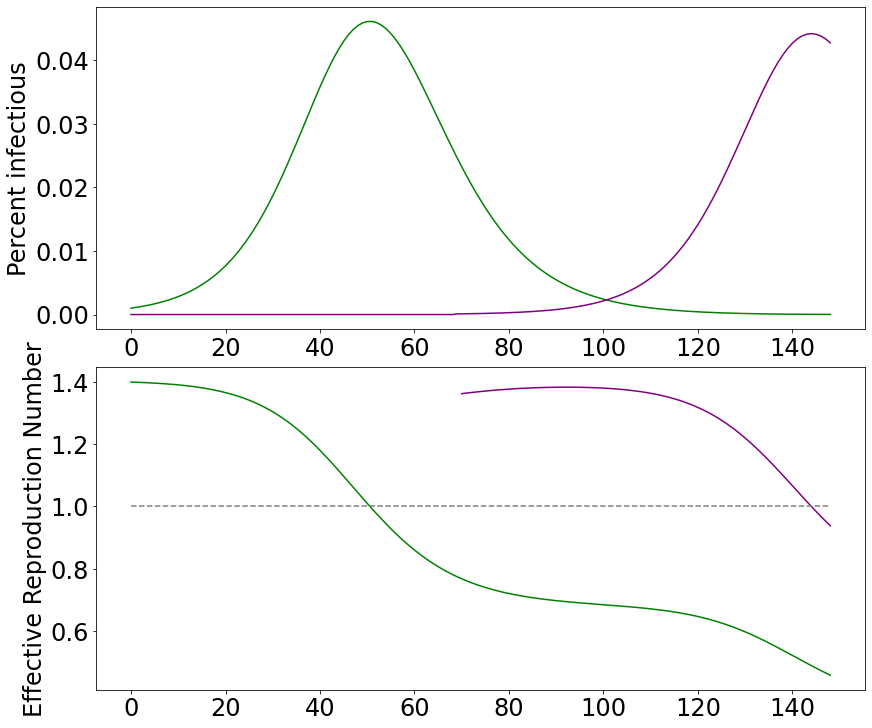

In [33]:
fig = plt.figure(figsize=(12., 10.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])

# Plotting infectious individuals
ax0.plot(t, Y[:, 1], label = "Wildtype", color = "green")
ax0.plot(t, Y[:, 2], label = "Immune Escaping Variant", color = "purple")
ax0.set_ylabel("Percent infectious")

# Plotting effective reproduction numbers
ax1.plot(t, Rt_wt, label = "Rt_w", color = "green")
ax1.plot(t[t > t0[-1]], Rt_v[t > t0[-1]], label = "Rt_v", color = "purple")
ax1.hlines(y=1.0, xmin = t[0], xmax = t[-1], color = "grey", linestyle = "--")
ax1.set_ylabel("Effective Reproduction Number")

In [34]:
# Simulating fake data based on cummulative incidence

def simulate_incidence(key, N_pop, Y):
    key1, key2, key3 = random.split(key, 3)
    
    EInc_wt = jnp.clip(jnp.diff(N_pop * Y[:, -2], prepend=0.), a_min = 0.0)
    EInc_v = jnp.clip(jnp.diff(N_pop * Y[:, -1], prepend=0.), a_min = 0.0)
    
    T =  len(EInc_wt)

    Inc_wt = random.poisson(key1, EInc_wt, shape= (T,))
    Inc_v = random.poisson(key2, EInc_v, shape= (T,))
    return key3, Inc_wt, Inc_v

N_pop = 20_000
key, Inc_wt, Inc_v = simulate_incidence(key, N_pop, Y)

In [35]:
def simulate_sequencing(key, Nsamples, Y):
    key1, key2 = random.split(key, 2)
        
    frac_v = jnp.divide(Y[:, 1][:,None], (Y[:,1] + Y[:,2])[:,None])
    T = len(frac_v)
    samples = random.bernoulli(key, p=frac_v, shape= (T, Nsamples)).sum(axis=1)
    return key, samples

N_samples = 100
key, samples = simulate_sequencing(key, N_samples, Y)

Text(0, 0.5, 'Variant Frequency')

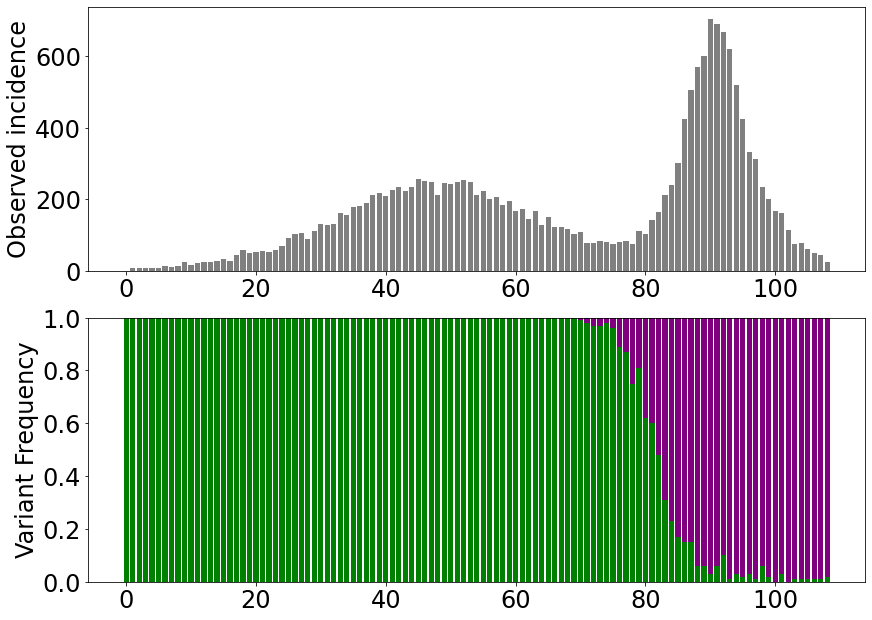

In [10]:
fig = plt.figure(figsize=(12., 8.5), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])

# Plotting observed incidence
ax0.bar(t, Inc_wt, label = "Wildtype", color = "grey")
ax0.bar(t, Inc_v, label = "Immune Escaping Variant", color = "grey", bottom=Inc_wt)
ax0.set_ylabel("Observed incidence")

# Plotting effective reproduction numbers
ax1.bar(t, samples / N_samples, color = "green")
ax1.bar(t, 1-samples/ N_samples,  color = "purple", bottom=samples/ N_samples)
ax1.set_ylabel("Variant Frequency")

# A More General Model

Let's consider a model with $V$ variants which differ from the base strain in terms of $\eta_{T}$, $\Sigma_{E}$, $\eta_{G}$. $\eta_{T}$ and $\eta_{T}$ are vectors with first component equal to 1, and $\Sigma_{E}$ is an escape matrix with diagonal elements 0.

\begin{align}
\frac{dS}{dt} &= - \beta_{\text{wt}} S \sum_{v=1}^{V} \eta_{T}^{v} I_{v}\\
\frac{dI_{v}}{dt} &= \beta_{\text{wt}} \left( \eta_{T}^{v} S I_{v} + \sum_{u=1}^{V} \Sigma_{E}^{u,v} R_{u} \right) I_{v} - \gamma_{\text{wt}} \eta_{G}^{v} I_{v} \\
\frac{dR_{v}}{dt} &= \gamma_{\text{wt}} \eta_{G}^{v} I_{v} - \left(\beta_{\text{wt}}\sum_{u=1}^V \Sigma_{E}^{v,u} I_{u} \right) R_{v}
\end{align}

We could also write this with matrix products and transposes.

This means that the vector of $R_{0}$ is going to become

$$
R^{v}_{0} = \frac{\eta_{T}^{v} \beta_{\text{wt}} }{\eta_{G}^{v} \gamma_{\text{wt}}}.
$$

Further, we have that 

$$
R^{v}_{t} = R^{v}_{0} \left( S + \sum_{v=1}^{V} \Sigma_{E}^{u, v} R_{u} \right) 
$$



In [ ]:
## How do variants move from different compartments?

In [ ]:
# Can we design a mutational path here, could we then simplify this path and infer it from data?